# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [1]:
from colorama import Fore, Back, Style 

import numpy as numpy
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math import requires_grad

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [2]:
max_iterations = 200
loop_count = 13

In [3]:

dev_1 = qml.device('default.qubit', wires=1)
dev_2 = qml.device('default.qubit', wires=1)
dev_3 = qml.device('default.qubit', wires=1)

## Classifier 1
weights_count = 3
init_weights_1 = (0.01 * np.random.randn(weights_count), 0.0)

print(init_weights_1)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=0) # input feature 2
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
weights_count = 6
init_weights_2 = (0.01 * np.random.randn(weights_count), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    qml.RY(data[1], wires=0) # input feature 2
    qml.Rot(weights[3], weights[4], weights[5], wires=0) # weight 2

    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
weights_count = 6
init_weights_3 = (0.01 * np.random.randn(weights_count), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    qml.RX(data[1], wires=0) # input feature 2
    qml.Rot(weights[3], weights[4], weights[5], wires=0) # weight 2
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


(tensor([-0.00699594,  0.00562203,  0.00492472], requires_grad=True), 0.0)


In [4]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = max_iterations
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)
      # print("trained weights and bias (var):", var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6741537 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6001138 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5064108 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4090988 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3236382 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2492050 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.1804682 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1231670 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.0725173 | Acc train: 0.5866667 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:    10 | Cost: 1.0369749 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:    11 | Cost: 1.0160877 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3985024 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3370039 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2609695 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.1867785 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.0989823 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.0129703 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     7 | Cost: 0.9488075 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.9009173 | Acc train: 0.6666667 | Acc val: 0.7200000 | Acc all: 0.6700000 
Iter:     9 | Cost: 0.8641560 | Acc train: 0.6800000 | Acc val: 0.8000000 | Acc all: 0.6800000 
Iter:    10 | Cost: 0.8410139 | Acc train: 0.7066667 | Acc val: 0.8000000 | Acc all: 0.7000000 
Iter:    11 | Cost: 0.8280835 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7041299 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6448734 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5385606 | Acc train: 0.4933333 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4380325 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3412382 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.2464082 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.1597084 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.0899922 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.0280469 | Acc train: 0.5333333 | Acc val: 0.6400000 | Acc all: 0.5300000 
Iter:    10 | Cost: 0.9775908 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 0.9497122 | Acc trai

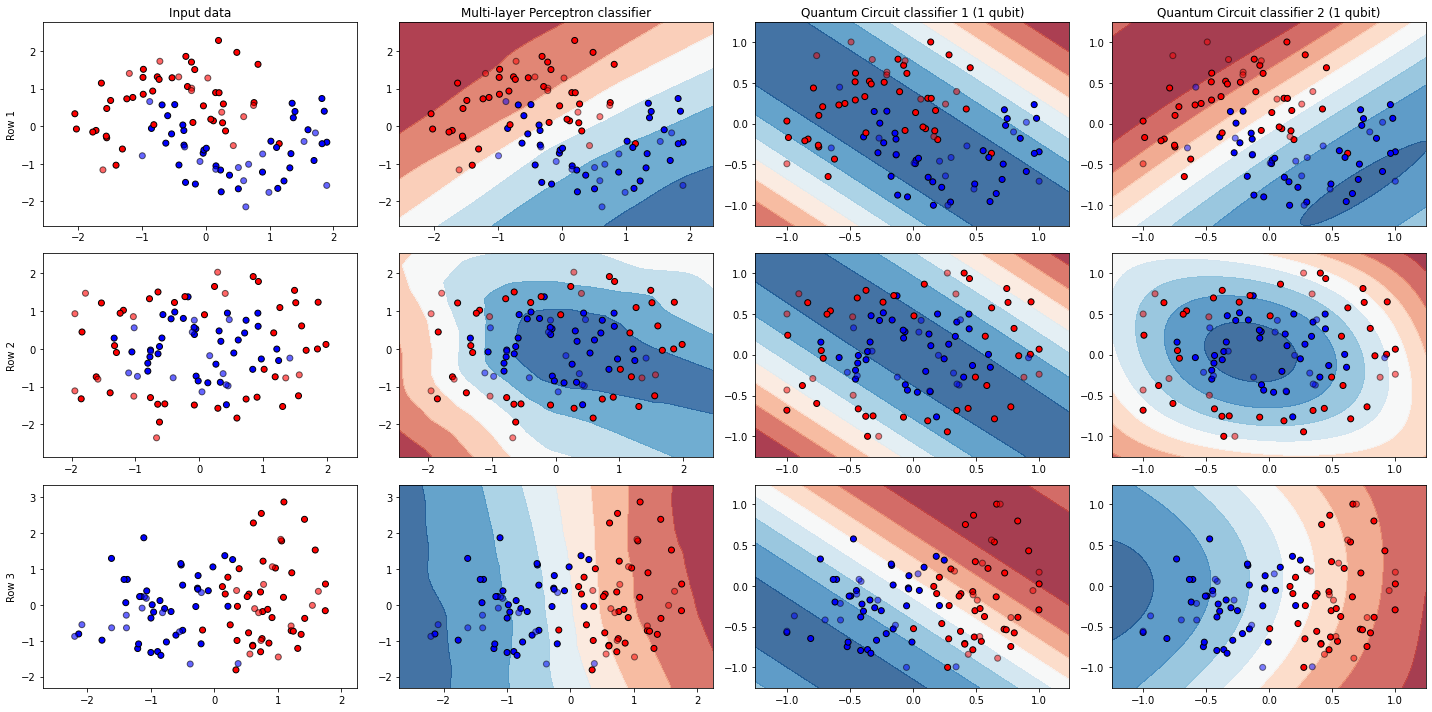

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6759875 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6072477 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5256887 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4103393 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.3103363 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2280631 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.1508706 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.0939486 | Acc train: 0.5866667 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     9 | Cost: 1.0475785 | Acc train: 0.5466667 | Acc val: 0.5200000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.0261968 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0183974 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3902508 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3314143 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2755576 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     4 | Cost: 1.2012009 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1320696 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.0572739 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     7 | Cost: 0.9850010 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9349317 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8939693 | Acc train: 0.6666667 | Acc val: 0.7200000 | Acc all: 0.6700000 
Iter:    10 | Cost: 0.8609951 | Acc train: 0.6800000 | Acc val: 0.8000000 | Acc all: 0.6900000 
Iter:    11 | Cost: 0.8376030 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7146374 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6690173 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6050719 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5128551 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.4168228 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.3178019 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1800270 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0258394 | Acc train: 0.6133333 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.8924449 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.7832640 | Acc train: 0.6533333 | Acc val: 0.7600000 | Acc all: 0.6700000 
Iter:    11 | Cost: 0.7057320 | Acc trai

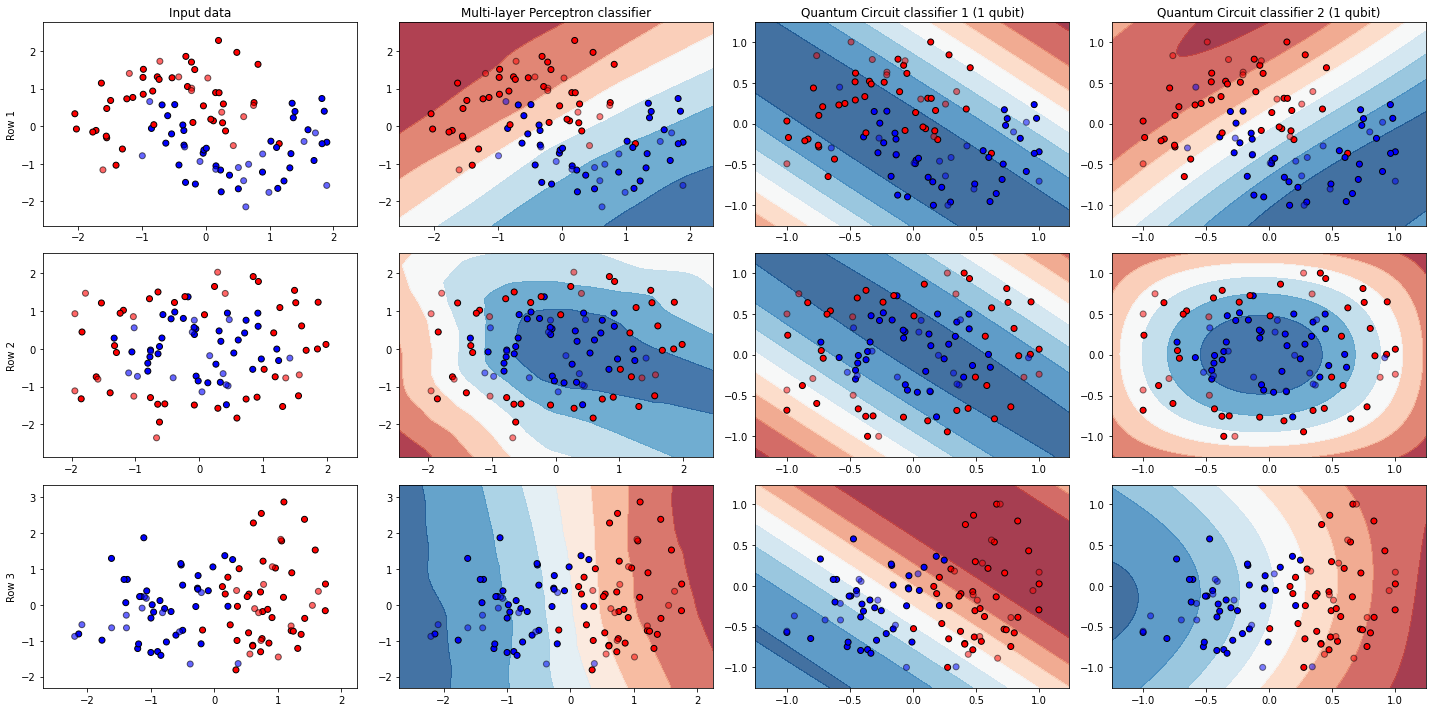

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6707076 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6123113 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5492219 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4800126 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4048784 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3242165 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     7 | Cost: 1.2394236 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1691693 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.1196501 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.0772108 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0385383 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3940229 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.3483493 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2953376 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2498624 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.1932423 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1177058 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.0534291 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.6000000 
Iter:     8 | Cost: 0.9975935 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     9 | Cost: 0.9473085 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.9034442 | Acc train: 0.6533333 | Acc val: 0.6800000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8736316 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7058483 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6656504 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5850071 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4891977 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.3926703 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.2763429 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1803281 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0720529 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9603378 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8677984 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.7851185 | Acc trai

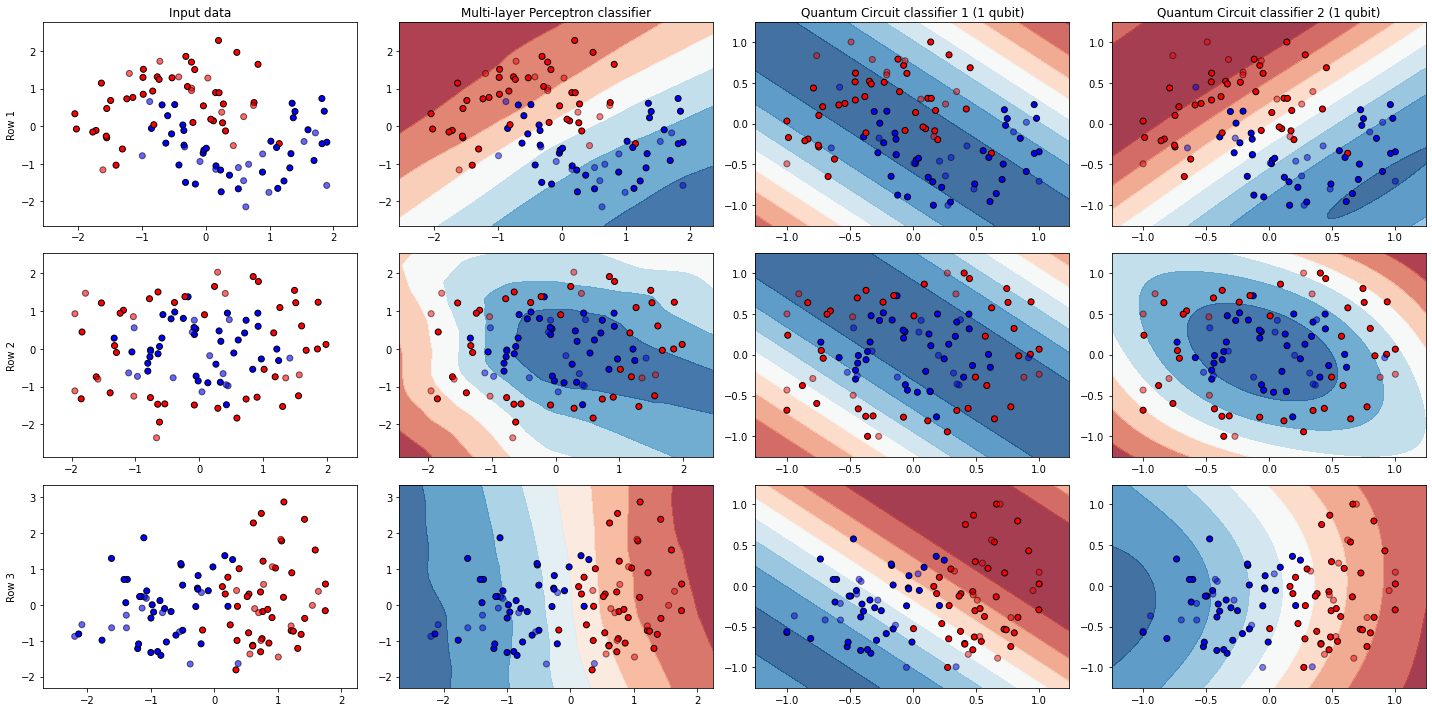

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6551268 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5754489 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.4973963 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4098675 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.3303011 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2446200 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.1742454 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.1145959 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.0678543 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.0417188 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.0290473 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3949903 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3571973 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3137347 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2498190 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.1619444 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0951245 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0312575 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9680594 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9177565 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8754051 | Acc train: 0.6800000 | Acc val: 0.7600000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.8470005 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7043208 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6602456 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5835775 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4838429 | Acc train: 0.4933333 | Acc val: 0.5200000 | Acc all: 0.4800000 
Iter:     5 | Cost: 1.3897898 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3143934 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.2465238 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.4800000 
Iter:     8 | Cost: 1.1737374 | Acc train: 0.4933333 | Acc val: 0.5200000 | Acc all: 0.4800000 
Iter:     9 | Cost: 1.1157418 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.4900000 
Iter:    10 | Cost: 1.0715737 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.0244160 | Acc trai

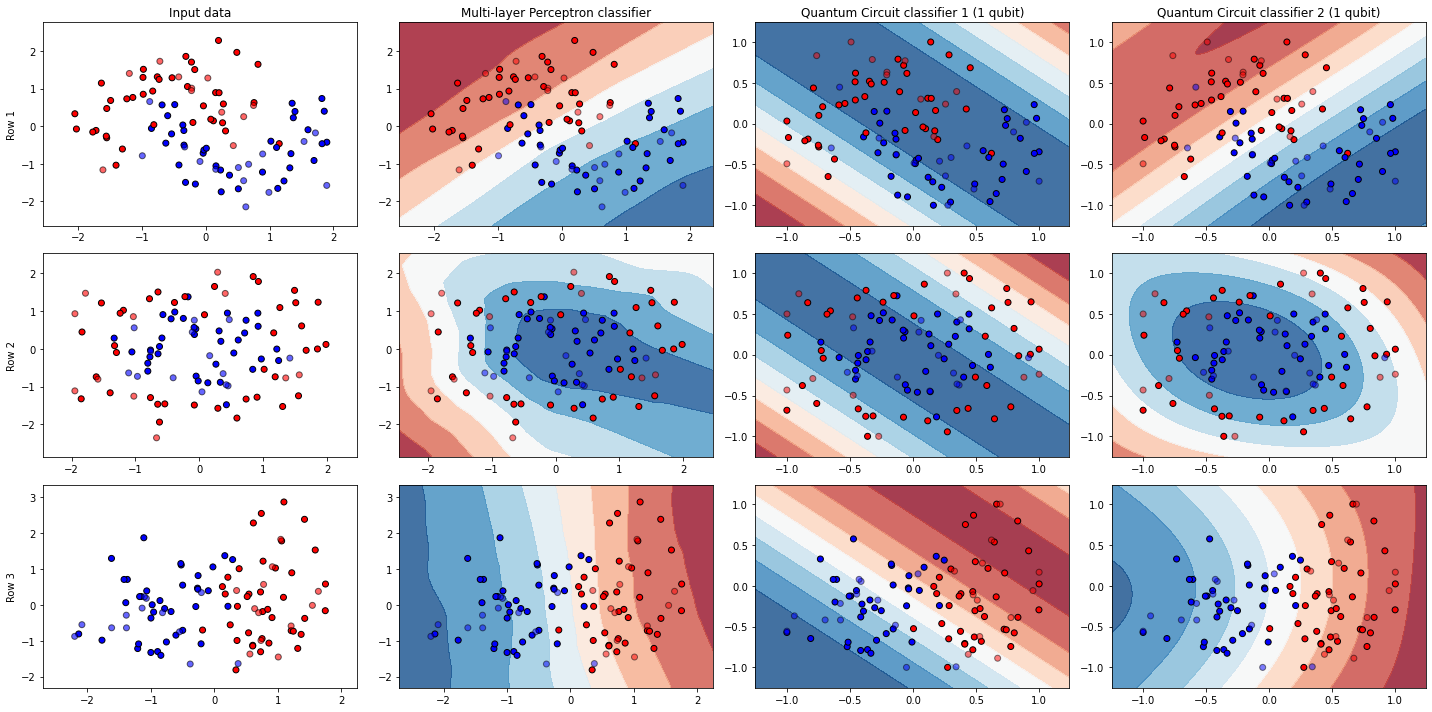

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6708367 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6223636 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5760576 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4999613 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4289310 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3819318 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.3272919 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.2684613 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     9 | Cost: 1.2239495 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:    10 | Cost: 1.1707422 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.1229139 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3921427 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3609365 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3147811 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2481387 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.1636177 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0770285 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0066650 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.9469470 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.8934193 | Acc train: 0.6666667 | Acc val: 0.7600000 | Acc all: 0.6700000 
Iter:    10 | Cost: 0.8585989 | Acc train: 0.6933333 | Acc val: 0.8000000 | Acc all: 0.6900000 
Iter:    11 | Cost: 0.8371070 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7271174 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.7211132 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6729625 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5923201 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.5226879 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.4543162 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.3688510 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.2447392 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.1094616 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:    10 | Cost: 0.9733467 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8504707 | Acc trai

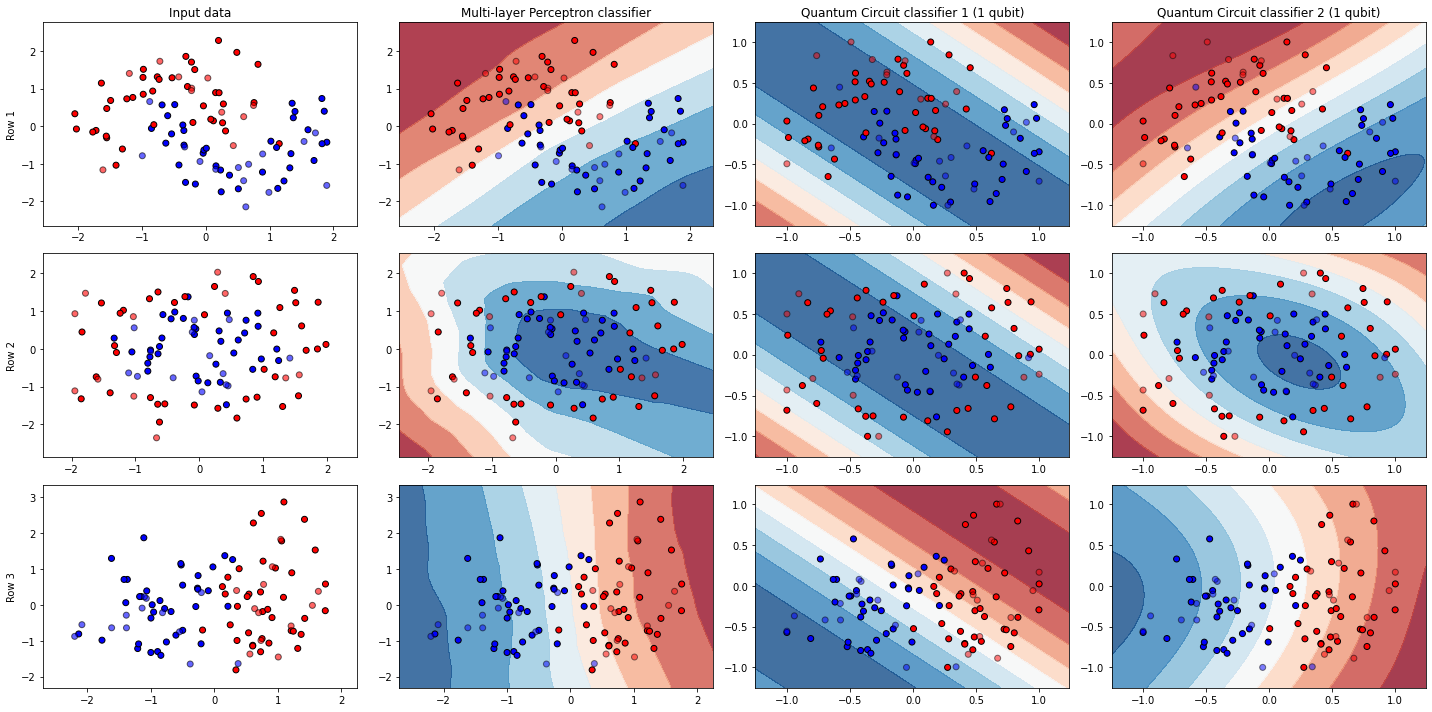

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6745160 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6199404 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5475216 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4630344 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3619406 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.2831866 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.2236275 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.1842094 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.1377878 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.1060866 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0781817 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3734411 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2998345 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     3 | Cost: 1.2106182 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     4 | Cost: 1.1375342 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.0727939 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.0144330 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     7 | Cost: 0.9663830 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.9188721 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:     9 | Cost: 0.8780029 | Acc train: 0.6666667 | Acc val: 0.6800000 | Acc all: 0.6800000 
Iter:    10 | Cost: 0.8556316 | Acc train: 0.7066667 | Acc val: 0.7200000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.8463843 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6913734 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6076212 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.4968655 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.3806384 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2491260 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.1227128 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     7 | Cost: 0.9981727 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.8928313 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:     9 | Cost: 0.8098922 | Acc train: 0.6533333 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.7502773 | Acc train: 0.6800000 | Acc val: 0.8800000 | Acc all: 0.6900000 
Iter:    11 | Cost: 0.7134488 | Acc trai

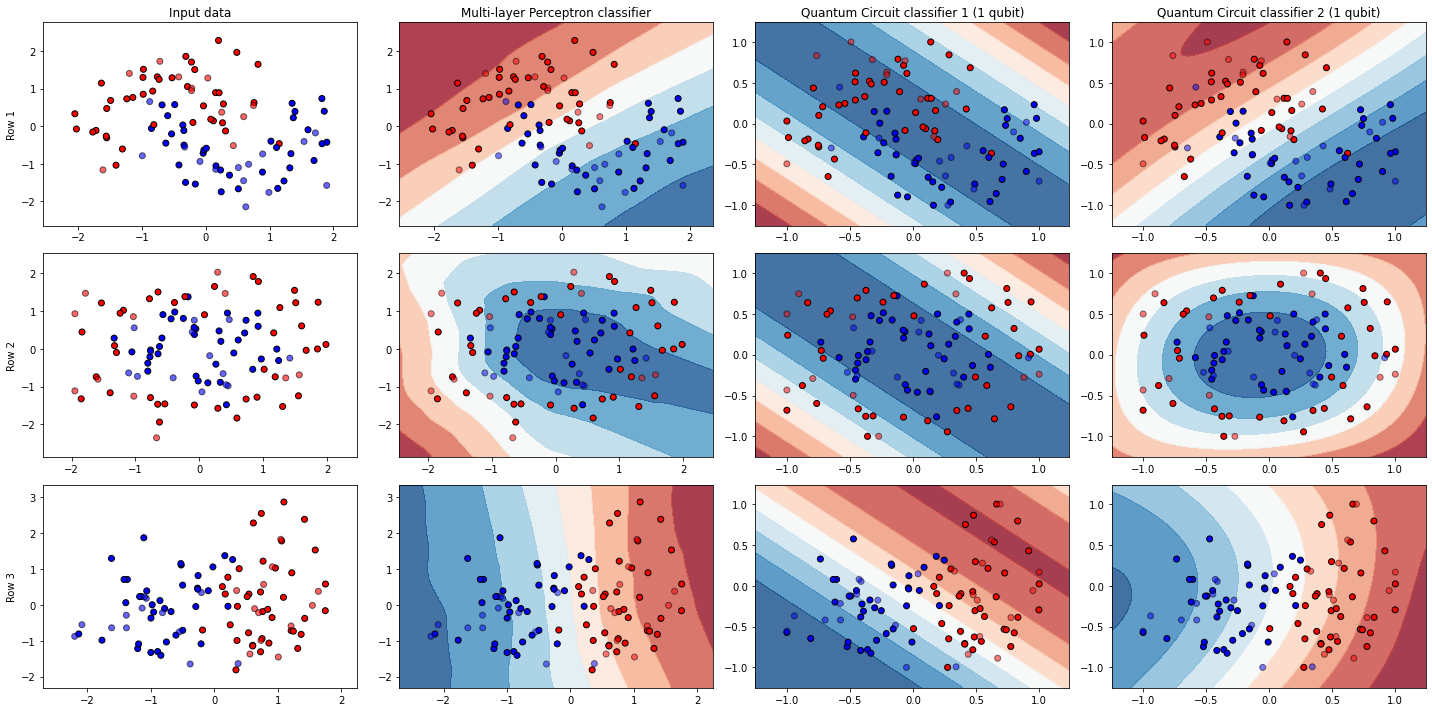

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6661453 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5943526 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.4968132 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.3830083 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.2813072 | Acc train: 0.4666667 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     6 | Cost: 1.1739244 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.0993397 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.0467809 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.0188105 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.0039840 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:    11 | Cost: 0.9982727 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4001337 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3626105 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3082425 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2465897 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1807026 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1346900 | Acc train: 0.5466667 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.0828583 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0181419 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     9 | Cost: 0.9536173 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.9030888 | Acc train: 0.6666667 | Acc val: 0.7200000 | Acc all: 0.6700000 
Iter:    11 | Cost: 0.8677696 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7029434 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6262888 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5527350 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4792748 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.4016798 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.3190435 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.2161291 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.1041944 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     9 | Cost: 0.9976113 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:    10 | Cost: 0.9046113 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:    11 | Cost: 0.8353953 | Acc trai

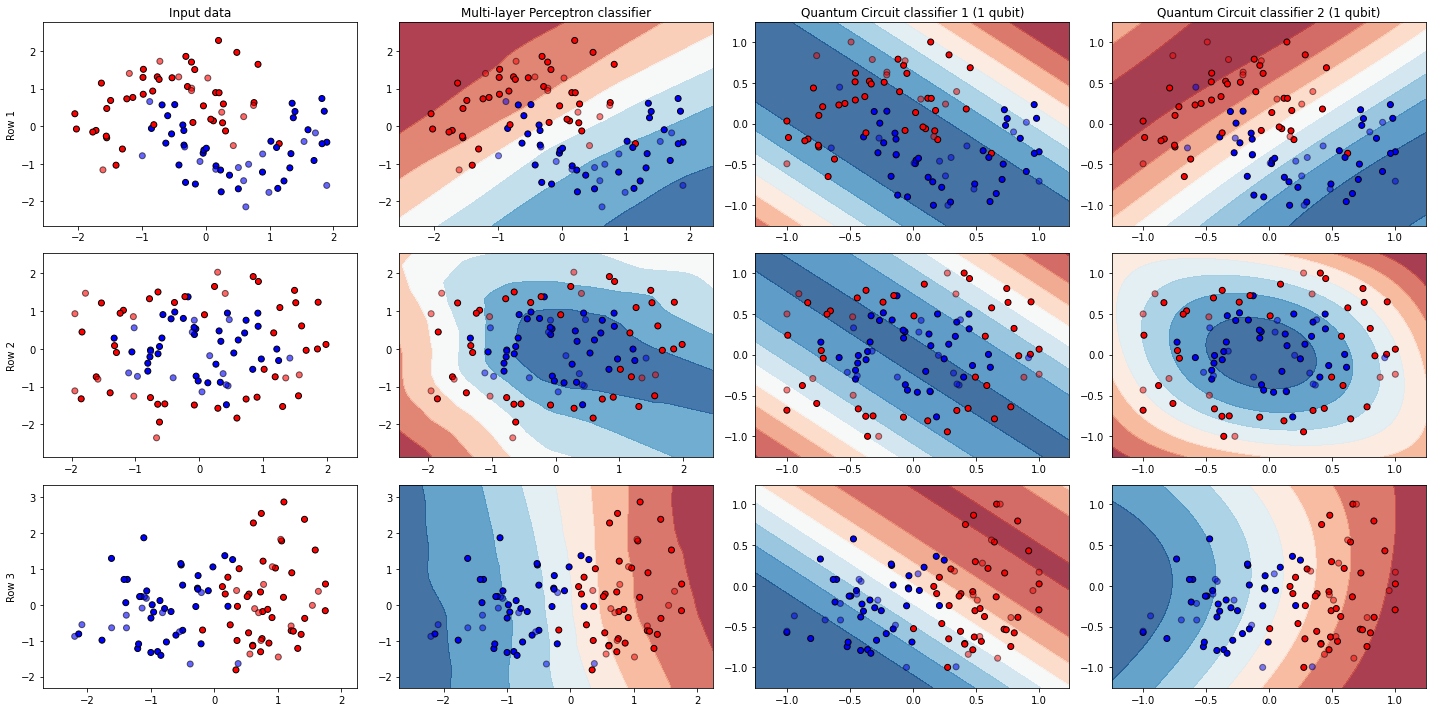

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6602770 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6056920 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5535416 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4828104 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4113933 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3439487 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2615802 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1863256 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.1176129 | Acc train: 0.6000000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.0606211 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.0210932 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4024353 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3883330 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3565667 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.3145568 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2665138 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.2118127 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1464474 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.0720253 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     9 | Cost: 1.0089660 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:    10 | Cost: 0.9466915 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.9094312 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7147911 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6770368 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6121121 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5174198 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4082736 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2963814 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1884885 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0830052 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     9 | Cost: 0.9948482 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:    10 | Cost: 0.9215788 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    11 | Cost: 0.8602884 | Acc trai

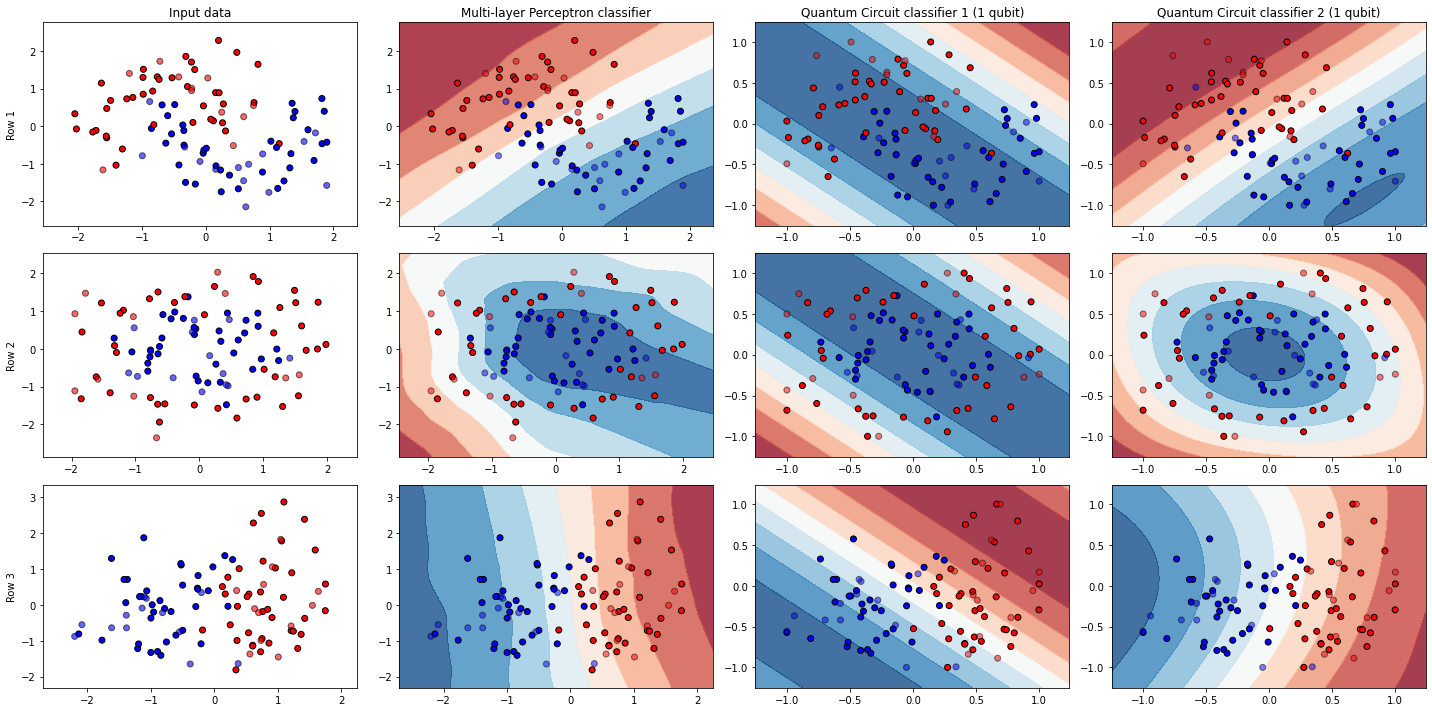

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6840587 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6527176 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.6021867 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5340836 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4654907 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3985690 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.3429734 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     8 | Cost: 1.2681563 | Acc train: 0.4666667 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     9 | Cost: 1.1979214 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.1334725 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.0900792 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3989279 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3410254 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2487236 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.1524467 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     5 | Cost: 1.0729747 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.0071198 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     7 | Cost: 0.9410605 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.8905825 | Acc train: 0.6533333 | Acc val: 0.6800000 | Acc all: 0.6600000 
Iter:     9 | Cost: 0.8563723 | Acc train: 0.7066667 | Acc val: 0.7200000 | Acc all: 0.6800000 
Iter:    10 | Cost: 0.8360977 | Acc train: 0.6800000 | Acc val: 0.7600000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.8296986 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7191501 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6795164 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.6212813 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5229860 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3823488 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2561543 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1487532 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0356693 | Acc train: 0.5866667 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9353361 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8612394 | Acc train: 0.6000000 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.7941400 | Acc trai

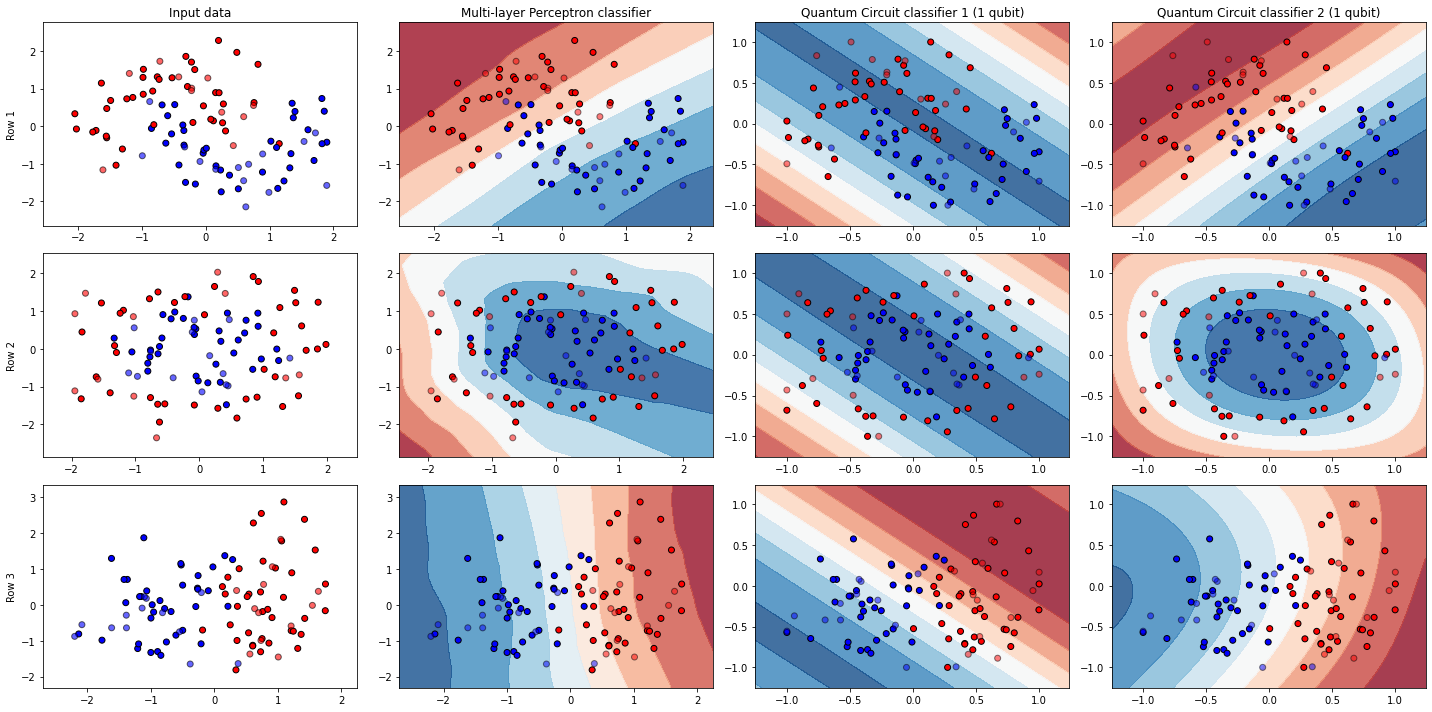

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7037226 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6797598 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.6217503 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5625449 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4988966 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.4432215 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.3883827 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.3183792 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.2562925 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:    10 | Cost: 1.1996751 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:    11 | Cost: 1.1464083 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4156149 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3596866 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3052459 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.2329862 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1517158 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.0662919 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     7 | Cost: 0.9816274 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.9251065 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:     9 | Cost: 0.8943896 | Acc train: 0.6666667 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8764392 | Acc train: 0.6933333 | Acc val: 0.6400000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.8672095 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6721735 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5749459 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.4489039 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.3203755 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.2047716 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.1021024 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.0236605 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9606926 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     9 | Cost: 0.9072703 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:    10 | Cost: 0.8510417 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8138727 | Acc trai

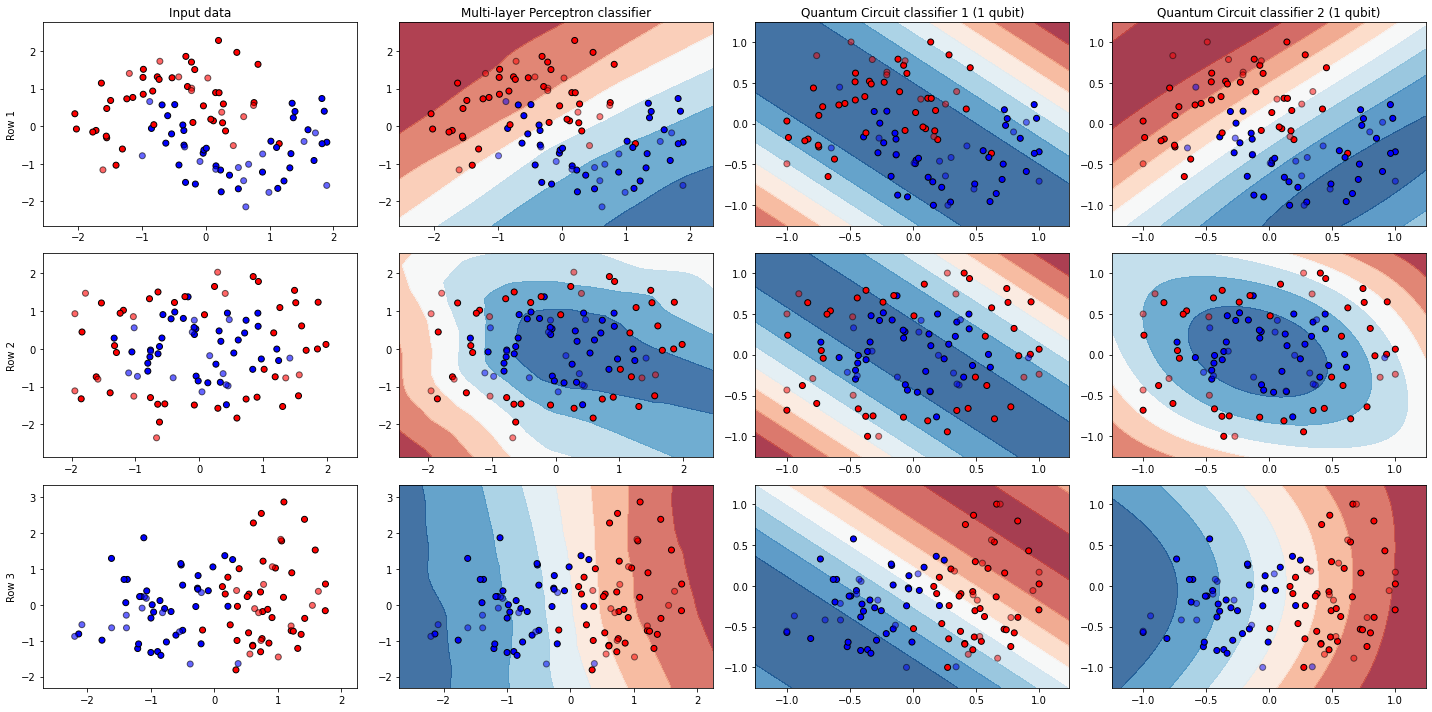

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6879725 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6649474 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.6122153 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5397470 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4853126 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.4245899 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.3431865 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2739659 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.2058698 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.1429253 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0917771 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4039627 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3770691 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3179635 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2733504 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2334297 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.1993742 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1571341 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.1116413 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     9 | Cost: 1.0691804 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:    10 | Cost: 1.0207961 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:    11 | Cost: 0.9690449 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7107750 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6799074 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.6194143 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5500400 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.4583968 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.3254620 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1947680 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0737224 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9325004 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8033722 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.6993568 | Acc trai

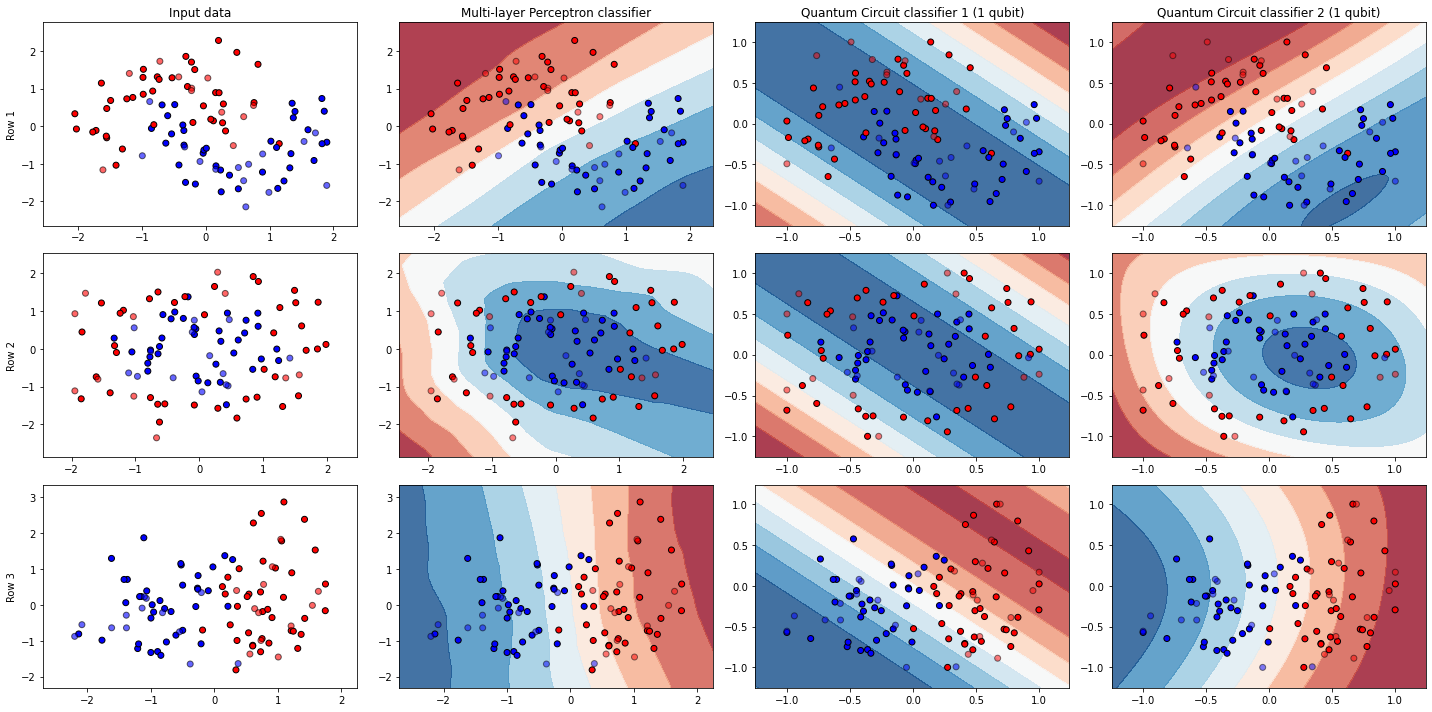

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6775441 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6295725 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5436396 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4386770 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3362568 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2373194 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.1582238 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.0906647 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     9 | Cost: 1.0545013 | Acc train: 0.5466667 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.0433922 | Acc train: 0.4666667 | Acc val: 0.4000000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.0508095 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3915274 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3698999 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3377552 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2976660 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2447077 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.1876320 | Acc train: 0.5466667 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1258243 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.0751007 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.0340193 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:    10 | Cost: 0.9919577 | Acc train: 0.6000000 | Acc val: 0.7200000 | Acc all: 0.6000000 
Iter:    11 | Cost: 0.9525000 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7142275 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6676352 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5952285 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5181795 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4182417 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.3312090 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.2435216 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.1412865 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     9 | Cost: 1.0422443 | Acc train: 0.5866667 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:    10 | Cost: 0.9555834 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.8771192 | Acc trai

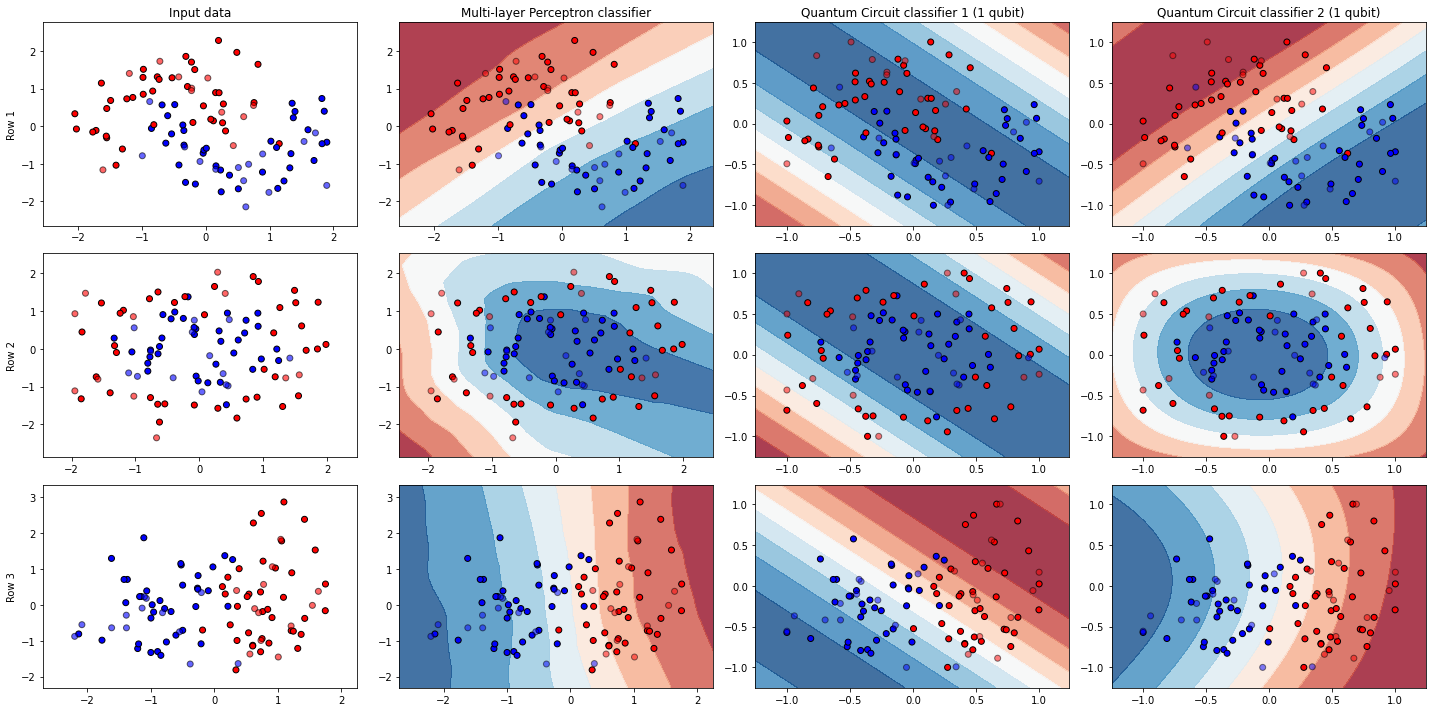

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7163479 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6909732 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.6279588 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5454252 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4761556 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3938459 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.3138220 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2388358 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     9 | Cost: 1.1719248 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.1075871 | Acc train: 0.6000000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.0561583 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3843327 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3472173 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3110176 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2648839 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.2223724 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.1828229 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.1288363 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0779515 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.0441067 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:    10 | Cost: 0.9982520 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:    11 | Cost: 0.9427591 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7102678 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6515682 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5591449 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4681048 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.3511798 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.2230953 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1029438 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0101281 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.9207313 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8345367 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.7631051 | Acc trai

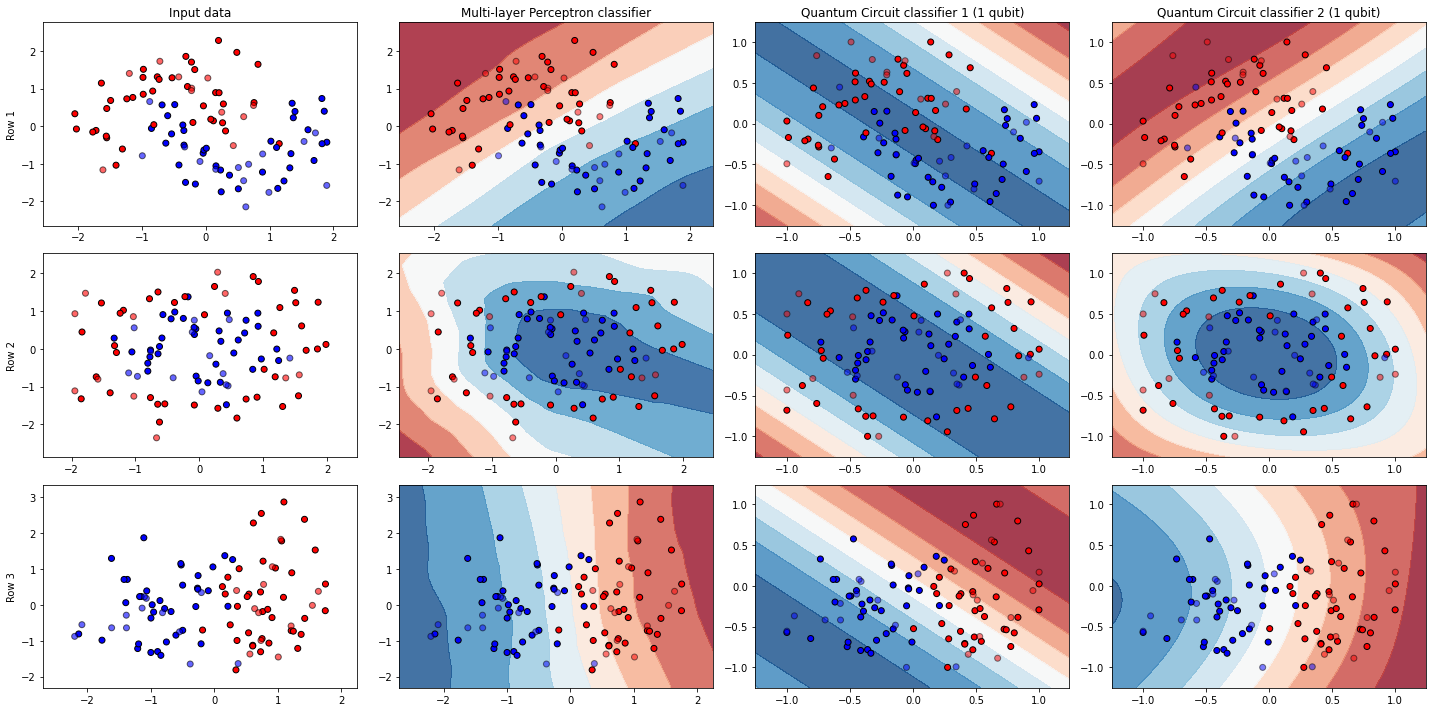

scores: [[[0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]
  [0.8  0.52 0.96]]

 [[0.44 0.8  0.84]
  [0.76 0.72 0.92]
  [0.6  0.68 0.88]
  [0.4  0.68 0.84]
  [0.44 0.68 0.84]
  [0.52 0.68 0.92]
  [0.8  0.76 0.92]
  [0.44 0.72 0.84]
  [0.4  0.8  0.84]
  [0.6  0.76 0.88]
  [0.64 0.68 0.92]
  [0.36 0.68 0.84]
  [0.56 0.76 0.84]]

 [[0.8  0.6  0.92]
  [0.84 0.72 0.96]
  [0.8  0.8  0.92]
  [0.84 0.84 0.96]
  [0.8  0.8  0.96]
  [0.84 0.8  0.96]
  [0.84 0.92 0.92]
  [0.84 0.92 0.88]
  [0.84 0.44 0.92]
  [0.8  0.8  0.92]
  [0.8  0.8  0.92]
  [0.84 0.44 0.92]
  [0.8  0.88 0.96]]]


In [5]:
halfPi = pi/2
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 100

names = [
    "Multi-layer Perceptron classifier",
    # "Linear SVM",
    # "Quantum classifier circuit 1",
    "Quantum Circuit classifier 1 (1 qubit)",
    "Quantum Circuit classifier 2 (1 qubit)",
]

classifiers = [
  MLPClassifier(random_state=1, max_iter=max_iterations, 
                    solver="sgd", nesterovs_momentum=True),
  # SVC(kernel="linear", C=0.025),
  # [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = numpy.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    linearly_separable, 
]

# initalize scores array
scores = np.zeros(shape=(len(classifiers),loop_count,len(datasets)))

#############
# Main Loop #
#############
for l_count in range(loop_count):
  figure = plt.figure(figsize=(20, 10))
  # Figure: set white background
  figure.patch.set_facecolor('xkcd:white')

  i = 1
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds
      
      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.25, random_state=1
      )
      x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
      y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      
      # scale data for quantum data
      y_train_quantum = np.where(y_train==0, y_train-1, y_train)
      y_test_quantum = np.where(y_test==0, y_test-1, y_test)
      y_quantum = np.where(y==0, y-1, y)
      
      scale_value=1
      X_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X)
      X_train_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_train)
      X_test_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_test)

      x_min_scaled, x_max_scaled = X_scaled[:, 0].min() - 0.25, X_scaled[:, 0].max() + 0.25
      y_min_scaled, y_max_scaled = X_scaled[:, 1].min() - 0.25, X_scaled[:, 1].max() + 0.25
      xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h), np.arange(y_min_scaled, y_max_scaled, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(["#FF0000", "#0000FF"])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      ax.set(ylabel='Row ' + str(ds_cnt+1))
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
      # Plot the testing points
      ax.scatter(
          X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
      )
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      #ax.set_xticks(())
      #ax.set_yticks(())
      i += 1

      classifier_count=0
      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

          if 'Quantum' in name:
            # Quantum circuit #
            vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train_quantum, y_test_quantum, y_quantum)
            Z = np.array(
              [clf[1](vars, f) for f in np.c_[xx_scaled.ravel(), yy_scaled.ravel()]]
            )

            # Put the result into a color plot
            Z = Z.reshape(xx_scaled.shape)
            ax.contourf(xx_scaled, yy_scaled, Z, cmap=cm, alpha=0.8)
            
            # Plot the training points
            ax.scatter(
                X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_quantum, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test_scaled[:, 0],
                X_test_scaled[:, 1],
                c=y_test_quantum,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx_scaled.min(), xx_scaled.max())
            ax.set_ylim(yy_scaled.min(), yy_scaled.max())
            
            # print scores
            # ax.text(
            #   xx_scaled.max() - 0.15,
            #   yy_scaled.min() + 0.15,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
            
          else:
            # Classical circuits #
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
                
            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())

            # print scores
            # ax.text(
            #   xx.max() - 0.3,
            #   yy.min() + 0.3,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
          
          scores[classifier_count][l_count][ds_cnt] = score
          # ax.set_xticks(())
          # ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          i += 1
          classifier_count += 1

  plt.tight_layout()
  plt.show()

print("scores:", scores)

In [6]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Quantum Circuit classifier 1 (1 qubit)
 0: ──RY(1.24)──Rot(-0.0349, 0.793, -0.0332)──RY(1.24)──Rot(0.0797, 0.796, -0.0049)──┤ ⟨Z⟩ 

Quantum Circuit classifier 2 (1 qubit)
 0: ──RY(1.24)──Rot(0.0795, 0.352, 0.0508)──RX(1.24)──Rot(0.00979, 1.02, 8.78e-05)──┤ ⟨Z⟩ 



C:\Users\zero\anaconda3\lib\site-packages\pennylane\qnode.py:838: UserWarning: The QNode.draw method has been deprecated. Please use the qml.draw(qnode)(*args) function instead.
  warnings.warn(
